In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import csv
import numpy as np
plt.rcParams['figure.figsize'] = (9,5)

## Read in the data

In [2]:
with open('sim_fast_s_turn.csv') as fin:
    csvin = csv.reader(fin)
    column_names = next(csvin)
    data_rows = []
    for r in csvin:
        data_rows.append([float(x) for x in r])
column_names

['Time', 'X', 'Y', 'Angle', 'EncoderLeft', 'EncoderRight', 'ForwardAccel']

## Compute Position from measurements
Use the yaw angle, not the angle from the encoders

In [3]:
class Encoder2Position(object):
    def __init__(self, wheel_base):
        self.wheel_base = wheel_base
        self.reset()
        return
    
    def reset(self):
        self.curr_pos = [0.0, 0.0, 0.0]
        self.prev_meas = [0.0, 0.0, 0.0]
        return
    
    def compute(self, l_enc, r_enc, yaw):
        d_l = l_enc - self.prev_meas[0]
        d_r = r_enc - self.prev_meas[1]
        d_theta = yaw - self.prev_meas[2]
        
        #print(l, r)
        # robot sim is backwards!! For now, make this agree
        #d_theta = (l - r) / self.wheel_base
        d_avg = (d_l + d_r) / 2.0
        #print(d_theta, d_avg)
        if abs(d_theta) < 1e-4:
            dx = d_avg
            dy = 0
        else:
            r_c = d_avg / d_theta
            dx = r_c * math.sin(d_theta)
            dy = r_c * (1.0 - math.cos(d_theta))

        self.curr_pos[2] += d_theta
        c = math.cos(self.curr_pos[2])
        s = math.sin(self.curr_pos[2])
            
        self.curr_pos[0] += dx*c - dy*s
        self.curr_pos[1] += dx*s + dy*c
        
        self.prev_meas[0] = l_enc
        self.prev_meas[1] = r_enc
        self.prev_meas[2] = yaw
        
        return self.curr_pos

In [4]:
enc2pos = Encoder2Position(22.0/12.0)
ind_l = column_names.index('EncoderLeft')
ind_r = column_names.index('EncoderRight')
ind_y = column_names.index('Angle')
pos_est = [(0, 0, 0, 0)]
for r in data_rows[1:]:
    pos = enc2pos.compute(r[ind_l], r[ind_r], r[ind_y])
    pos_est.append((r[0], pos[0], pos[1], pos[2]))

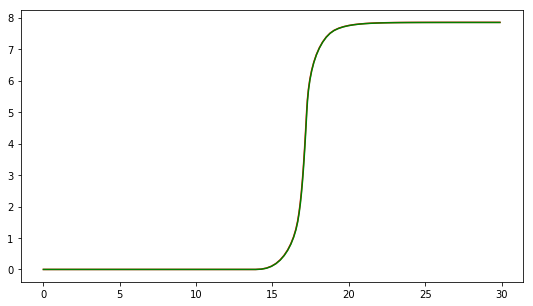

In [5]:
plt.rcParams['figure.figsize'] = (9,5)

# Just check that the calc is good

# note r[0] is time
x_est = [r[1] for r in pos_est]
y_est = [r[2] for r in pos_est]
plt.plot(x_est, y_est, color='red')

x_real = [r[1] for r in data_rows]
y_real = [r[2] for r in data_rows]
plt.plot(x_real, y_real, color='green');

In [6]:
def plot_fit(title, t, real, sim, kal, cov):
    plt.rcParams['figure.figsize'] = (16,5)
    
    f, (ax1, ax2) = plt.subplots(1, 2)
#    print(ax1)
    ax1.set_title(title)
    ax1.plot(t, real, color='green')
    ax1.plot(t, sim, color='blue')
    ax1.plot(t, kal, color='red')
    dx = np.sqrt(cov)
    ax1.plot(t, np.add(kal, dx), color='orange')
    ax1.plot(t, np.subtract(kal, dx), color='orange')
    
    ax2.set_title(title + ' - Difference from Real')
    #plt.plot(t, x_real, color='green')
    ax2.plot(t, np.subtract(sim, real), color='blue')
    ax2.plot(t, np.subtract(kal, real), color='red')
    ax2.plot(t[1:], np.subtract(np.add(kal, dx), real)[1:], color='orange')
    ax2.plot(t[1:], np.subtract(np.subtract(kal, dx), real)[1:], color='orange')
    plt.show()
    return

In [7]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn

dt = 0.05

np.random.seed(1234)

t = [r[0] for r in data_rows]
x_real = [r[1] for r in data_rows]
y_real = [r[2] for r in data_rows]
a_real = [math.degrees(r[3]) for r in data_rows]

## Regular linear Kalman filter
This won't be optimal, but let's see what it looks like

Variables are x, vx, y, vy, angle, vangle

Measurements should be wheel encoder values. However, that requires non-linear calcs. *Cheat*: precalculate the x, y, and angle from the encoder.

In [8]:
meas_dEnc, meas_da = 1./12., math.radians(1.0)
zs3 = [np.array([r[1] + randn()*meas_dEnc, r[2] + randn()*meas_dEnc, r[3] + randn()*meas_da]) for r in pos_est]

In [9]:
def run_kalman(uncertainty_accel, uncertainty_angle_acc):
    kf = KalmanFilter(6, 3)
    kf.x = np.array(6*[0.,])
    kf.F = np.array([[1, dt, 0,  0, 0,  0], 
                     [0,  1, 0,  0, 0,  0],
                     [0,  0, 1, dt, 0,  0],
                     [0,  0, 0,  1, 0,  0],
                     [0,  0, 0,  0, 1, dt],
                     [0,  0, 0,  0, 0,  1]])

    kf.R = np.diag([meas_dEnc**2, meas_dEnc**2, meas_da**2])
    kf.H = np.array([[1, 0, 0, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0],
                     ])
 
    kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=uncertainty_accel**2)
    kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=dt, var=uncertainty_accel**2)
    kf.Q[4:6, 4:6] = Q_discrete_white_noise(2, dt=dt, var=uncertainty_angle_acc**2)
                     
    # We could use the "batch_filter" method, but let's use what we would in real life
    xs3 = [np.copy(kf.x), ]
    xcov3 = [np.copy(kf.P), ]
    for r in zs3[1:]:
        kf.predict()
        kf.update(r)
        xs3.append(np.copy(kf.x))
        xcov3.append(np.copy(kf.P))
        
    return xs3, xcov3

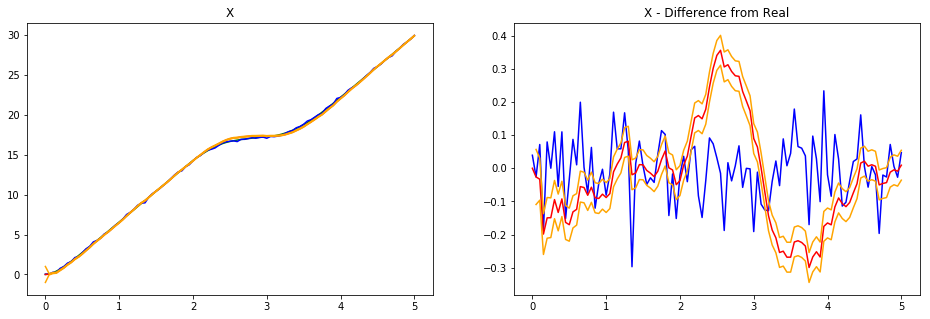

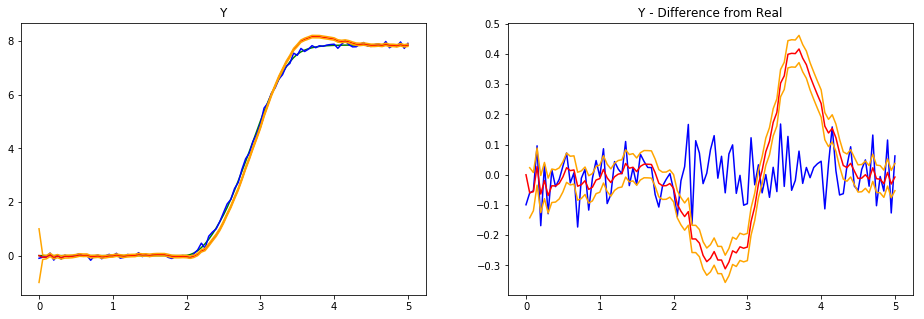

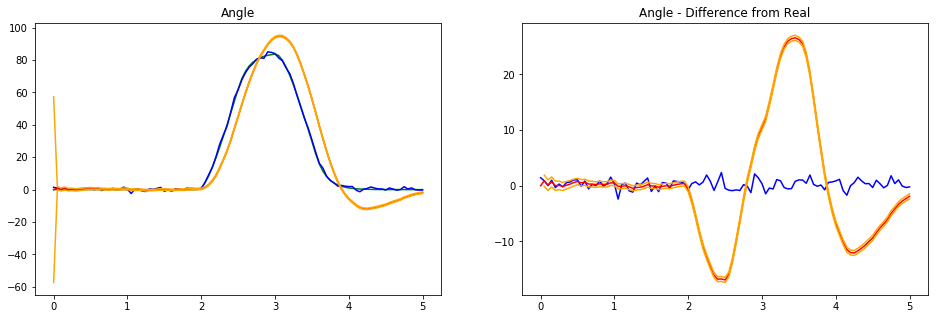

In [10]:
# acceleration uncertainty of 2 ft/sec/sec and 10deg/sec/sec. 
xs3, xcov3 = run_kalman(2.0, math.radians(10.0))

x_sim = [r[0] for r in zs3]
x_kal = [r[0] for r in xs3]
x_cov = [m[0,0] for m in xcov3]
plot_fit("X", t, x_real, x_sim, x_kal, x_cov)

y_sim = [r[1] for r in zs3]
y_cov = [m[2,2] for m in xcov3]
y_kal = [r[2] for r in xs3]
plot_fit("Y", t, y_real, y_sim, y_kal, y_cov)

a_k = [math.degrees(r[4]) for r in xs3]
a_sim = [math.degrees(r[2]) for r in zs3]
a_cov = [math.degrees(math.sqrt(m[4,4]))**2 for m in xcov3]
plot_fit("Angle", t, a_real, a_sim, a_k, a_cov);

The problem is that there is no acceleration in the model. It does OK for the first few seconds, probably because the acceleration is low, but really falls behind when the angle starts changing (because the model angle uncertainty is low).

# Let's increase the model uncertainty

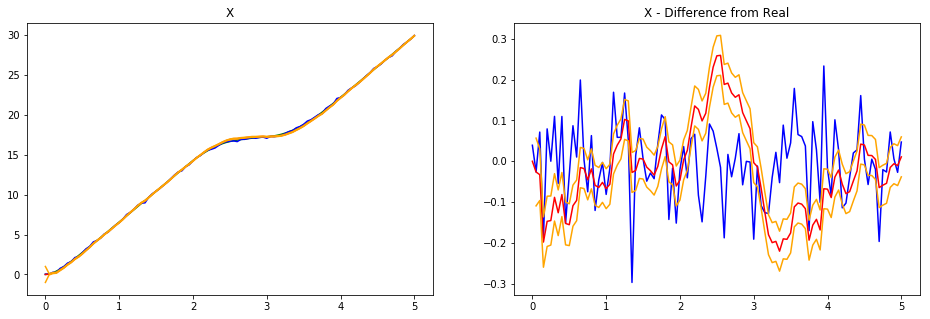

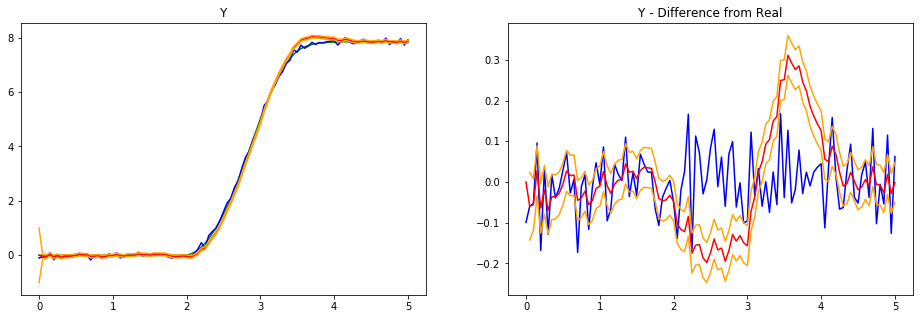

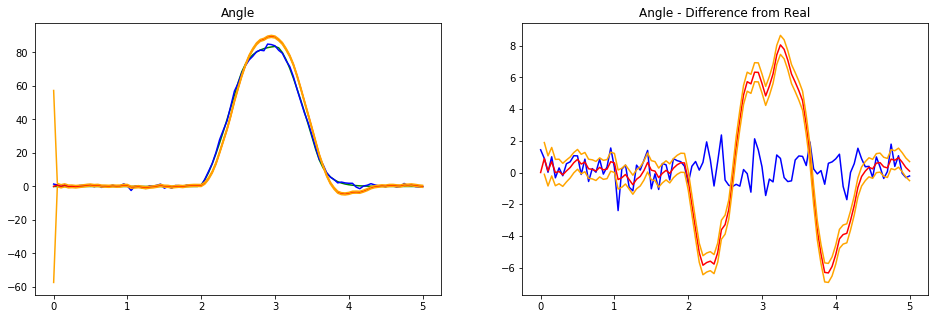

In [11]:
# 3 ft/sec/sec and 40 deg/sec/sec
# the speed is probably OK, but that is pretty fast turning.
xs3, xcov3 = run_kalman(3.0, math.radians(40.0))

plt.rcParams['figure.figsize'] = (16,5)
x_sim = [r[0] for r in zs3]
x_kal = [r[0] for r in xs3]
x_cov = [m[0,0] for m in xcov3]
plot_fit("X", t, x_real, x_sim, x_kal, x_cov)

y_sim = [r[1] for r in zs3]
y_cov = [m[2,2] for m in xcov3]
y_kal = [r[2] for r in xs3]
plot_fit("Y", t, y_real, y_sim, y_kal, y_cov)

a_k = [math.degrees(r[4]) for r in xs3]
a_sim = [math.degrees(r[2]) for r in zs3]
a_cov = [math.degrees(math.sqrt(m[4,4]))**2 for m in xcov3]
plot_fit("Angle", t, a_real, a_sim, a_k, a_cov);

So, this looks better. **However**:
* it still is clearly not tracking the turns well. The distance error is not bad, but the angle is off by ~7.5 degrees
* IMPORTANT: we are still cheating. The "measurements" are calculated positions based on the encoders. We know that is not great in real life. So it will only be worse.